Import Libraries

In [2]:
import pandas as pd # for data manipulation
import numpy as np # for numerical analysis
import joblib

# for plotting graphs
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
# Style settings
%matplotlib inline
sns.set_style("darkgrid")

Import Dataset

In [4]:
dementia = pd.read_csv("dementia_dataset.csv")

In [5]:
# check first 5 rows of data
dementia.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Check basic information of the dataset

In [6]:
dementia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


## Data Preprocessing

### Feature Engineering

Mapping Ordinal values to numerical values

In [7]:
group = {
    "Nondemented" : 0,
    "Demented" : 1,
    "Converted" : 2
}
dementia["Group"] = dementia["Group"].map(group)

In [8]:
gender = {
    "M" : 1,
    "F" : 0
}
dementia["M/F"] = dementia["M/F"].map(gender)

Correlations

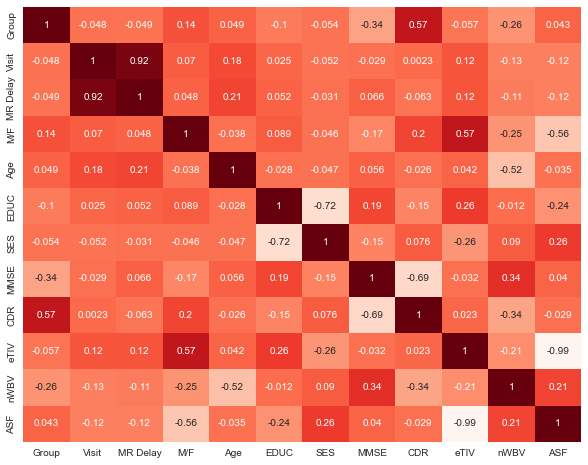

In [9]:
plt.figure(figsize=[10, 8])
sns.heatmap(dementia.corr(), annot=True, cbar=False, cmap="Reds");
# (MR delay-Visit*), (educ-ses), (etiv-asf*) high correlated

The relationship between eTIV and ASF is almost perfectly correlated negatively, which may be the cause of the high correlation

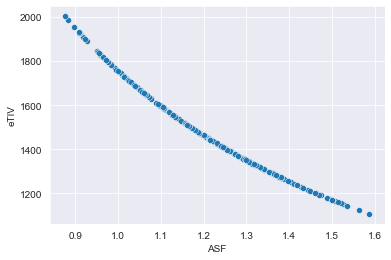

In [10]:
sns.scatterplot(data=dementia, y="eTIV", x="ASF");

As we can see below whenever the number of visits is 1, the MR Delay equals 0

In [11]:
dementia[dementia["Visit"] == 1]["MR Delay"].sample(10)

256    0
327    0
312    0
105    0
201    0
268    0
322    0
218    0
13     0
318    0
Name: MR Delay, dtype: int64

Dropping highly correlated data

In [12]:
dementia.drop(["Visit", "ASF"], axis=1, inplace=True)

Also whenever the CDR feature equals to 1 or 0 its maps to Demented and Non-demented respectively, this column will be dropped to make the model more intelligent

In [13]:
dementia[dementia["CDR"] == 1]["Group"].sample(10)

366    1
316    1
317    1
250    1
26     1
332    1
88     1
12     1
106    1
308    1
Name: Group, dtype: int64

All patients are right-handed so this feature isnt useful

In [14]:
dementia["Hand"].value_counts()

R    373
Name: Hand, dtype: int64

Data Shuffle

In [15]:
dementia = dementia.sample(frac=1, random_state=11).copy()

Dropping unuseful features
* Subject ID - id of pateint
* MRI ID - id of mri scan for each patient
* Hand - all patients are right handed

In [16]:
dementia.drop(["Subject ID", "MRI ID", "Hand", "CDR"], axis=1, inplace=True)

Focus of pateint is Demented or Not Demented, so converted patients are not needed

In [17]:
mask = dementia.loc[dementia["Group"] == 2].index
dementia.drop(mask, inplace=True)

### Data Split

In [18]:
from sklearn.model_selection import train_test_split
X = dementia.drop("Group", axis=1) 
y = dementia["Group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

Rows and instances in train and test set respectively

In [19]:
X_train.shape, X_test.shape

((235, 8), (101, 8))

In [20]:
# Renaming X_train to demnetia
dementia = X_train.copy()
dementia

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV
61,642,1,92,12,3.0,24.0,1311,0.676
335,0,1,76,16,3.0,30.0,1832,0.769
138,1282,0,82,8,5.0,18.0,1464,0.682
29,0,1,80,12,3.0,29.0,1783,0.752
210,1218,0,80,11,4.0,30.0,1586,0.757
...,...,...,...,...,...,...,...,...
255,597,0,88,16,3.0,30.0,1295,0.744
41,0,0,61,16,3.0,30.0,1313,0.805
276,539,0,71,11,4.0,28.0,1284,0.741
94,575,0,85,15,2.0,22.0,1483,0.748


Extracting numerical features

In [21]:
numerical = [col for col in dementia.columns if dementia[col].dtype != "O"]

### Missing data Imputation

Checking features that have missing data

In [22]:
dementia.isna().sum()

MR Delay     0
M/F          0
Age          0
EDUC         0
SES         12
MMSE         0
eTIV         0
nWBV         0
dtype: int64

Importing library used for handling missing data

In [23]:
from sklearn.impute import SimpleImputer

Using median to replace missing values as the data contains outliers

In [24]:
imputer = SimpleImputer(strategy="median")

Imputing the data

In [25]:
imputer.fit(dementia[numerical])
dementia[numerical] = imputer.transform(dementia[numerical])

Checking features that have missing data

In [26]:
dementia.isna().sum()

MR Delay    0
M/F         0
Age         0
EDUC        0
SES         0
MMSE        0
eTIV        0
nWBV        0
dtype: int64

## Data Normalization

Extracting features that will be scaled

In [27]:
numerical_scale = ['MR Delay','Age','EDUC','SES','MMSE','eTIV','nWBV']

Importing library for scaling

In [28]:
from sklearn.preprocessing import StandardScaler

Scaling features to a range of -3 to 3 to boost model performance

In [29]:
scaler = StandardScaler()
scaler.fit(dementia[numerical_scale])
dementia[numerical_scale] = scaler.transform(dementia[numerical_scale])

In [30]:
joblib.dump(scaler, "scaler_joblib")

['scaler_joblib']

In [31]:
dementia

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV
61,0.043460,1.0,2.095859,-0.886918,0.431669,-0.797246,-0.982130,-1.508032
335,-0.955755,1.0,-0.011771,0.543104,0.431669,0.725948,1.793144,1.001718
138,1.039563,0.0,0.778590,-2.316940,2.310226,-2.320439,-0.167126,-1.346112
29,-0.955755,1.0,0.515136,-0.886918,0.431669,0.472082,1.532129,0.542947
210,0.939953,0.0,0.515136,-1.244424,1.370948,0.725948,0.482746,0.677879
...,...,...,...,...,...,...,...,...
255,-0.026578,0.0,1.568952,0.543104,0.431669,0.725948,-1.067359,0.327054
41,-0.955755,0.0,-1.987675,0.543104,0.431669,0.725948,-0.971476,1.973234
276,-0.116850,0.0,-0.670406,-1.244424,1.370948,0.218216,-1.125954,0.246094
94,-0.060819,0.0,1.173771,0.185599,-0.507610,-1.304977,-0.065917,0.435000


## Model Building

In [32]:
# renaming data to X_train
X_train = dementia.copy()

Preprocessing Validation data

In [33]:
X_test[numerical] = imputer.transform(X_test[numerical])

In [34]:
X_test[numerical_scale] = scaler.transform(X_test[numerical_scale])

In [35]:
X_test.head()

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV
213,0.525947,0.0,-0.275225,1.258115,-0.507610,0.725948,-0.508043,0.542947
28,0.144627,1.0,1.832405,-2.316940,1.370948,-1.051111,0.919545,-2.317628
87,-0.191558,0.0,-0.406952,-0.886918,1.370948,-0.289515,-0.236375,0.677879
328,0.010776,1.0,1.042044,-0.171907,-0.507610,-1.304977,0.290980,-1.804884
222,-0.232024,1.0,-0.670406,0.543104,-1.446889,-2.574305,0.354902,-1.265153


### Bagging

Importing library for bagging .i.e Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
bagger = RandomForestClassifier(random_state=51, n_jobs=-1, n_estimators=40, max_depth=15)

In [38]:
bagger.fit(X_train, y_train)
predictions = bagger.predict(X_test)

#### Bagging Performance

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,  recall_score

In [40]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %") 
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 87.13 %
The f1 score is 83.54 %
The recall is 80.49 %


Confusion Matrix
|   | 0  | 1  |
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

Text(0.5, 1.0, 'Confusion Matrix - Bagging')

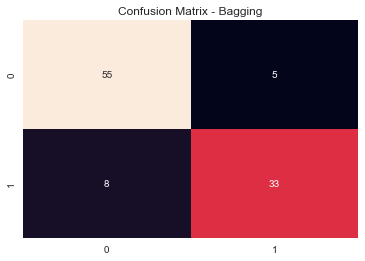

In [41]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
plt.title('Confusion Matrix - Bagging')
# TN   FP
# FN*   TP - Recall

### Stacking


Algorithms used for stacking
*   Decision Tree
*   Naive Bayes
*   KNN

In [42]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [43]:
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=4, max_leaf_nodes=4, random_state=51)),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=10))]

In [44]:
stacker = StackingClassifier(estimators)

In [45]:
stacker.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=4,
                                                       max_leaf_nodes=4,
                                                       random_state=51)),
                               ('nb', GaussianNB()),
                               ('knn', KNeighborsClassifier(n_neighbors=10))])

In [46]:
predictions = stacker.predict(X_test)

#### Stacking Performance

In [47]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %") 
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 85.15 %
The f1 score is 81.01 %
The recall is 78.05 %


Confusion Matrix
|   | 0  | 1  |
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

Text(0.5, 1.0, 'Confusion Matrix - Stacking')

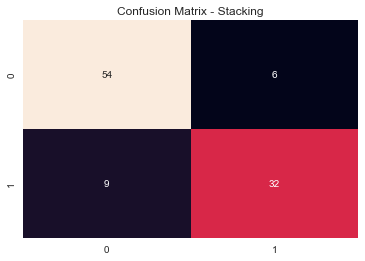

In [48]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
plt.title('Confusion Matrix - Stacking')
# TN   FP
# FN*   TP - Recall

### Boosting

In [49]:
from xgboost import XGBClassifier

In [50]:
booster = XGBClassifier(random_state=51, n_estimators=60, max_depth=23, learning_rate=0.5)

In [51]:
booster.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=23, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=51, ...)

In [52]:
predictions = booster.predict(X_test)

#### Boosting Performance

In [53]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %") 
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 86.14 %
The f1 score is 83.72 %
The recall is 87.80 %


Confusion Matrix
|   | 0  | 1  |
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

Text(0.5, 1.0, 'Confusion Matrix - Boosting')

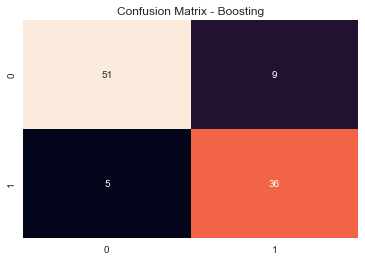

In [54]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
plt.title('Confusion Matrix - Boosting')
# TN   FP
# FN*   TP - Recall

### Saving The Model

In [55]:
joblib.dump(booster, "model_joblib")

['model_joblib']

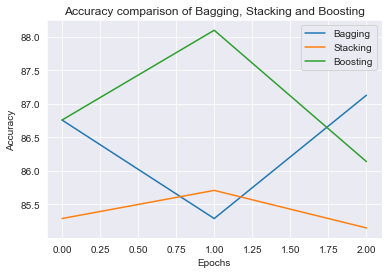

In [56]:
bagging_acc = [86.76, 85.29, 87.13] # accuracy of bagging algorithm 
stacking_acc = [85.29,85.71,85.15] # accuracy of stacking algorithm
boosting_acc = [86.76,88.10,86.14] # accuracy of boosting algorithm

bagging_f1 = [83.64,82.14,83.54] # F1 score of bagging algorithm
stacking_f1 = [80.77,81.25,81.01] # F1 score of stacking algorithm
boosting_f1 = [83.64,84.85,83.72] # F1 score of boosting algorithm

bagging_recall = [85.19,85.19,80.49] # recall of bagging algorithm
stacking_recall = [77.78,81.25,78.05] # recall of stacking algorithm
boosting_recall = [85.19,87.50,87.80] # recall of boosting algorithm

# Plot the accuracy graph
plt.plot(bagging_acc, label='Bagging')
plt.plot(stacking_acc, label='Stacking')
plt.plot(boosting_acc, label='Boosting')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy comparison of Bagging, Stacking and Boosting')
plt.legend()
plt.show()



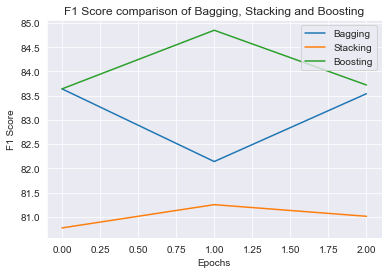

In [57]:
# Plot the F1 score graph
plt.plot(bagging_f1, label='Bagging')
plt.plot(stacking_f1, label='Stacking')
plt.plot(boosting_f1, label='Boosting')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score comparison of Bagging, Stacking and Boosting')
plt.legend()
plt.show()



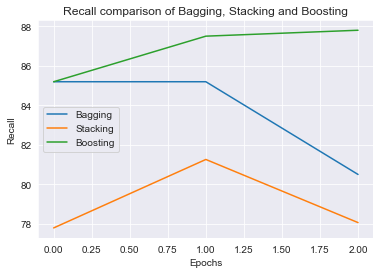

In [58]:
# Plot the recall graph
plt.plot(bagging_recall, label='Bagging')
plt.plot(stacking_recall, label='Stacking')
plt.plot(boosting_recall, label='Boosting')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall comparison of Bagging, Stacking and Boosting')
plt.legend()
plt.show()

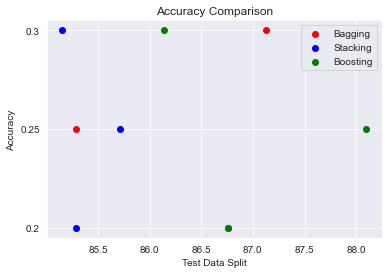

In [59]:
# Plot the scatter plot for accuracy
plt.scatter(bagging_acc, [0, 1, 2], color='red', label='Bagging')
plt.scatter(stacking_acc, [0, 1, 2], color='blue', label='Stacking')
plt.scatter(boosting_acc, [0, 1, 2], color='green', label='Boosting')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Test Data Split')
plt.yticks([0, 1, 2], ['0.2', '0.25', '0.3'])
plt.title('Accuracy Comparison')
plt.show()

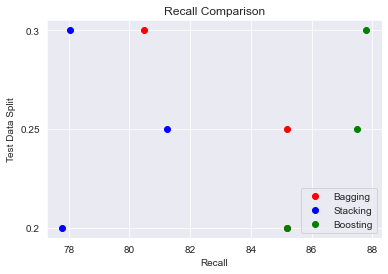

In [60]:
# Plot the scatter plot for recall
plt.scatter(bagging_recall, [0, 1, 2], color='red', label='Bagging')
plt.scatter(stacking_recall, [0, 1, 2], color='blue', label='Stacking')
plt.scatter(boosting_recall, [0, 1, 2], color='green', label='Boosting')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Test Data Split')
plt.yticks([0, 1, 2], ['0.2', '0.25', '0.3'])
plt.title('Recall Comparison')
plt.show()

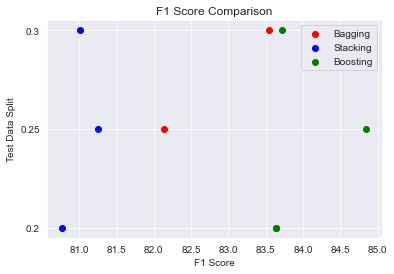

In [61]:
# Plot the scatter plot for f1 score
plt.scatter(bagging_f1, [0, 1, 2], color='red', label='Bagging')
plt.scatter(stacking_f1, [0, 1, 2], color='blue', label='Stacking')
plt.scatter(boosting_f1, [0, 1, 2], color='green', label='Boosting')
plt.legend()
plt.xlabel('F1 Score')
plt.ylabel('Test Data Split')
plt.yticks([0, 1, 2], ['0.2', '0.25', '0.3'])
plt.title('F1 Score Comparison')
plt.show()

In [62]:
# Get the maximum accuracy
max_acc = max(bagging_acc, stacking_acc, boosting_acc)

# Get the method with maximum accuracy
if max_acc == bagging_acc:
    best_method = "bagging"
elif max_acc == stacking_acc:
    best_method = "stacking"
else:
    best_method = "boosting"

print("The method with maximum accuracy is: ", best_method)

# Get the maximum F1 score
max_f1 = max(bagging_f1, stacking_f1, boosting_f1)

# Get the method with maximum F1 score
if max_f1 == bagging_f1:
    best_f1_method = "bagging"
elif max_f1 == stacking_f1:
    best_f1_method = "stacking"
else:
    best_f1_method = "boosting"

print("The method with maximum F1 score is: ", best_f1_method)

# Get the maximum recall
max_recall = max(bagging_recall, stacking_recall, boosting_recall)

# Get the method with maximum recall
if max_recall == bagging_recall:
    best_recall_method = "bagging"
elif max_recall == stacking_recall:
    best_recall_method = "stacking"
else:
    best_recall_method = "boosting"

print("The method with maximum recall is: ", best_recall_method)

# Compare the best method for accuracy, F1 score and recall
if best_method == best_f1_method == best_recall_method:
    print("The best method for accuracy, F1 score, and recall is: ", best_method)
else:
    print("The best method for accuracy is: ", best_method)
    print("The best method for F1 score is: ", best_f1_method)
    print("The best method for recall is: ", best_recall_method)

The method with maximum accuracy is:  boosting
The method with maximum F1 score is:  boosting
The method with maximum recall is:  boosting
The best method for accuracy, F1 score, and recall is:  boosting
